In [1]:
import cv2
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

import glob
import os.path as op

In [2]:
def imshow(img, cmap=None):
    plt.imshow(img, cmap)
    plt.show()

In [3]:
def load_data(data_path, data_ext):
    images = []
    for filename in sorted(glob.glob(op.join(data_path, '*.'+data_ext))):
        print(filename)
        
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        
        imshow(img)
    
    return np.array(images)

images/parrington/prtn00.jpg


images/parrington/prtn01.jpg


images/parrington/prtn02.jpg


images/parrington/prtn03.jpg


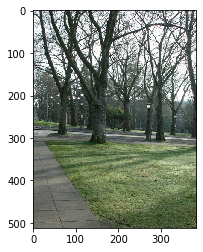

images/parrington/prtn04.jpg


images/parrington/prtn05.jpg


images/parrington/prtn06.jpg


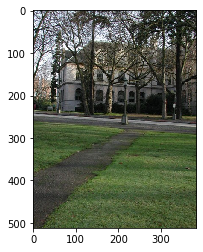

images/parrington/prtn07.jpg


images/parrington/prtn08.jpg


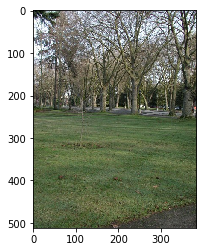

images/parrington/prtn09.jpg


images/parrington/prtn10.jpg


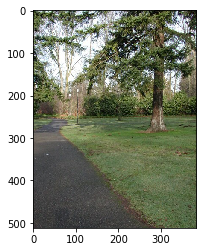

images/parrington/prtn11.jpg


images/parrington/prtn12.jpg


images/parrington/prtn13.jpg


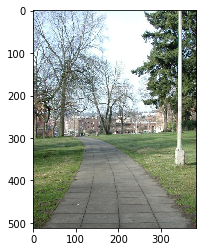

images/parrington/prtn14.jpg


images/parrington/prtn15.jpg


images/parrington/prtn16.jpg


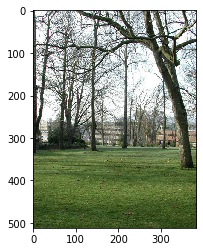

images/parrington/prtn17.jpg


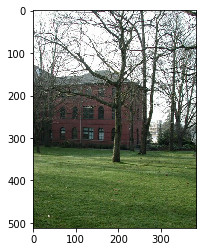

(18, 512, 384, 3)


In [4]:
img_set = load_data('images/parrington', 'jpg')
print(img_set.shape)

In [67]:

def localMaximum(I, threshold, ks=(3, 3)):
    # get coords of value greater then threshold
    coords = np.argwhere(I > threshold)
    print(coords.shape)
    
    # padding: mirror (h+2, w+2, c)
    I_p = cv2.copyMakeBorder(I, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    
    # collect local-maxima
    local_maxima = []
    for coord in coords:
        # plus 1 for padding
        x, y = coord + 1
        
        if np.all(I_p[x, y] - I_p[x-1:x+2, y-1:y+2] >= 0):
            local_maxima.append(coord)
                                
    return np.array(local_maxima)
    
def subPixelRefinement(I, coords):
    
    # padding: mirror (h+2, w+2, c)
    I_p = cv2.copyMakeBorder(I, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    
    sp_coords = []
    values = []
    for coord in coords:
        # plus 1 for padding
        x, y = coord + 1
        
        # 1st order derivative (gradient)
        g = np.array([[I_p[x+1, y] - I_p[x-1, y]], [I_p[x, y+1] - I_p[x, y-1]]]) / 2
        # 2nd order derivative (Hassian matrix)
        h_a = I_p[x-1, y] - 2*I_p[x, y] + I_p[x+1, y]
        h_b = I_p[x, y-1] - 2*I_p[x, y] + I_p[x, y+1]
        h_c = (I_p[x-1, y-1] - I_p[x-1, y+1] - I_p[x+1, y-1] + I_p[x+1, y+1]) / 4
        H = np.array([[h_a, h_c], [h_c, h_b]])
        
        # accurate maximum location
        dcoord_m = -np.matmul(la.inv(H), g)
        
        # TODO: change sampled pixel
        if dcoord_m[0, 0] > 0.5:
            print('change x', dcoord_m[0, 0])
        if dcoord_m[1, 0] > 0.5:
            print('change y', dcoord_m[1, 0])
        
        # maximum
        value = I_p[x, y] + 1/2 * np.matmul(g.transpose(), dcoord_m)
        
        # collect result
        sp_coords.append(coord + np.reshape(dcoord_m, 2))
        values.append(value[0, 0])

    return sp_coords, values
    

# TODO: Adaptive Non-Maximum Suppression
def ANMS(img, nums):
    pass


# determinant and trace of Harris Matrix
def Harris(I, ks=(5, 5), sig_i=1.5, sig_d=1.0):
    # convert to float (0 ~ 1)
    I_f = I.astype(np.float32) / 255.0
    
    # gradient (h, w, c)
    # padding: mirror (h+2, w+2, c)
    I_f = cv2.copyMakeBorder(I_f, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    # filter: [-1, 0, 1] (h, w, c)
    g_x = (I_f[2:, 1:-1] - I_f[:-2, 1:-1]) / 2
    g_y = (I_f[1:-1, 2:] - I_f[1:-1, :-2]) / 2
    #imshow(g_x)
    #imshow(g_y)
    
    # blurred gradient (h, w, c)
    I_x = cv2.GaussianBlur(g_x, ks, sig_d)
    I_y = cv2.GaussianBlur(g_y, ks, sig_d)
    #imshow(I_x)
    #imshow(I_y)
    
    # (h, w, c)
    S_x2 = cv2.GaussianBlur(I_x * I_x, ks, sig_i)
    S_y2 = cv2.GaussianBlur(I_y * I_y, ks, sig_i)
    S_xy = cv2.GaussianBlur(I_x * I_y, ks, sig_i)
    #imshow(S_x2)
    #imshow(S_y2)
    #imshow(S_xy)
    
    # Harris Matrix (h, w, 2, 2, c)
    #H_l = np.moveaxis([[S_x2, S_xy], [S_xy, S_y2]], (0, 1), (2, 3))
    
    # determinant and trace (h, w, c)
    #det_H = H_l[:, :, 0, 0]*H_l[:, :, 1, 1] - H_l[:, :, 1, 0]*H_l[:, :, 0, 1]
    #tr_H = np.trace(H_l, axis1=2, axis2=3)
    det_H = S_x2 * S_y2 - S_xy * S_xy
    tr_H = S_x2 + S_y2
    #imshow(det_H)
    #imshow(tr_H)
    
    return det_H, tr_H

def HarrisCornerDetector(img, k=0.05, th=1):
    '''
    Arguments:
        img: gray-scale image
    '''
    
    # Harris (h, w, c)
    det_H, tr_H = Harris(img)
    
    # response (h, w, c)
    R = det_H - k*np.power(tr_H, 2)
    #imshow(R)
    #print(np.max(R), np.min(R))
    
    # thresholding & find local-maxima
    threshold = 0.01 * R.max()
    local_maxima = localMaximum(R, threshold)
    
    # non-maximum suppression
    #ANMS()
    
    # sub-pixel refinement
    keypoints, _ = subPixelRefinement(R, local_maxima)
    
    
    return local_maxima
    
def MSOPDescriptor(I, f_HM, ks=(5, 5), sig_o=4.5):
    # convert to float (0 ~ 1)
    I_f = I.astype(np.float32) / 255.0
    
    # gradient (h, w, c)
    # padding: mirror (h+2, w+2, c)
    I_f = cv2.copyMakeBorder(I_f, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    # filter: [-1, 0, 1] (h, w, c)
    g_x = I_f[2:, 1:-1] - I_f[:-2, 1:-1]
    g_y = I_f[1:-1, 2:] - I_f[1:-1, :-2]
    
    # blurred gradient (h, w, c)
    I_x = cv2.GaussianBlur(g_x, ks, sig_o)
    I_y = cv2.GaussianBlur(g_y, ks, sig_o)
    
    # major orientation (h, w, c)
    cos_theta = I_x / np.abs(I_x)
    sin_theta = I_y / np.abs(I_y)


# Multi-Scale Oriented Patches
def MSOP(img, ks=(5, 5), sig_p=1.0, sig_i=1.5, sig_d=1.0, th=10.0):
    '''
    Arguments:
        img: gray-scale image
    '''
    
    # Multi-Scale Harris Corner Detector
    P = []
    f_HM = []
    
    P_l = img
    for i in range(3):
        # add layer to pyramid
        P.append(P_l)
        # compute Harris
        det_H, tr_H = Harris(P[-1])
        # corner detection function
        # FIXME: deal with tr_H=0
        f_HM.append(det_H / tr_H)
        print('f_HM')
        imshow(f_HM[-1])
        
        # local-maxima
        local_maxima = localMaximum(f_HM[-1], th)
        
        # non-maximum suppression
        #ANMS(f_HM[-1])
        
        # sub-pixel refinement
        keypoints, _ = subPixelRefinement(f_HM[-1], local_maxima)
        
        # next layer
        # gaussian blur
        P_l = cv2.GaussianBlur(P[i], ks, sig_p)
        # down sampling
        P_l = P_l[::2, ::2]


In [66]:
def HarrisLib(img):
    img_gray = cv2.cvtColor(img_set[0], cv2.COLOR_RGB2GRAY)
    dst = cv2.cornerHarris(img_gray, 5, 3, 0.05)
    print(dst.max(), dst.min())
    imshow(dst)
    
    dst = cv2.dilate(dst, None)
    
    img_c = np.copy(img)
    
    img_c[dst>0.01*dst.max()] = [255, 0, 0]
    
    imshow(img_c)
    
    return dst
    
    

In [7]:
def drawPoints(img, coords):
    img_c = np.copy(img)
    
    for x, y in coords:
        img_c[x, y] = [255, 0, 0]
        
    imshow(img_c)
    

In [62]:
img_gray = []
for img in img_set:
    img_gray.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    
img_gray = np.array(img_gray)

(10684, 2)
change y 0.56122931263678
change x 0.5124084432718856
change y 0.7356995445475606
change y 0.5066837424261165
change x 0.5500233729892231
change y 0.6393089688719247
change x 0.5339898541435217
change x 2.2207323093416402
change y 1.359235467440084
change x 0.5881557180201257
change y 0.5834917908434959
change x 0.5147589380073444
change y 0.516982762636955
change x 0.6696735057349414
change y 0.9890413999205021
(545, 2)


(11308, 2)
change y 0.6613274742520574
change x 0.5114623949851517
change x 0.5050242267398455
change x 0.5271992722907476
change y 1.2319300346042672
change x 0.5049202904614121
change y 0.799443967213034
change x 0.5006586345887346
change x 0.5308545347450103
change y 0.5823356478896271
change y 0.5156024496900152
change x 0.5883769154087978
change y 1.686506444577765
change y 0.8443680254156563
change x 0.5506974032058853
change x 1.4596972592987896
change y 0.6171413333392458
change x 0.5123489170028814
change y 0.5362191973735179
change x 0.8119075666407793
change y 0.6628813839938745
change x 0.6021780315732211
change y 0.5300835593229883
change x 0.5395996769481759
change y 0.5564398090573527
change y 0.5523691257544275
change y 0.7405169304315831
change y 0.5722874609825608
change x 0.5221487996019281
change x 0.5275283697584878
change y 0.7197912634127464
change x 0.524410604373871
change x 0.5071389151139035
change y 0.5611912156927771
change y 0.5028862104293541
change x 0.5

(22459, 2)
change x 0.7858662409489062
change y 0.7654233747005498
change x 0.6530026593173488
change y 0.5043101997156643
change y 0.538532156136705
change y 0.683532605952476
change y 0.5541109360512727
change x 1.5882929161087482
change y 0.9843146798509227
change y 0.5115540759339446
change x 0.5283809169310829
change y 0.5253285845670929
change y 0.5418207976772277
change y 0.7158109855587913
change y 0.5582143538225839
change y 0.5097140856150555
change y 0.5483409842872227
change y 0.8678331605984377
change x 0.5733914017682398
change x 0.5117408763267987
change y 0.8608799355748991
change y 2.5139728622890227
change x 0.9588214223511438
change x 0.6417246434488929
change x 0.5031824644841736
change x 0.5072928173118377
change y 0.5019489607423587
change y 0.5738159878885948
change x 0.5408992333600114
change x 0.5041157193141359
change x 0.5156110346269269
change y 0.5394691840515098
change x 0.6338343782081363
change y 0.5017484884595176
change x 0.5415370263570114
change x 1.

(24321, 2)
change y 0.5252917151157889
change y 0.5071827578362158
change x 0.7364918832429895
change x 0.5043307951496837
change x 0.5235582215425648
change y 0.5021043239613329
change x 0.5182179469361167
change x 0.5047162243720817
change x 0.5255989624277912
change y 0.5001525527715137
change x 0.5090679989495173
change x 0.5735710862949194
change y 0.5083197229067271
change x 0.5758527657217942
change x 0.696200527982924
change x 0.5246963000163121
change x 1.3844816436573184
change y 0.5540665562126692
change x 0.5299648949126846
change x 0.6830881440507378
change x 0.503957890893934
change x 0.515108401236717
change x 0.5111021577434652
change x 0.8529867642629796
change x 0.7886505136902388
change y 1.3613140522630278
change y 0.5122280857688207
change y 0.5824552352464987
change x 0.9599175120750002
change y 0.5665905090430415
change x 0.5432588752514778
change y 0.5893846768454816
change y 0.5223044071914525
change x 0.5770296022513296
change y 0.5021343061314328
change y 0.5

(14321, 2)
change x 0.5176996091750449
change y 3.1872637027815394
change y 1.0498473932571402
change y 0.7249861143361539
change x 0.503083093821306
change x 0.532272815288251
change x 0.5159869761959214
change x 0.5256455851341076
change y 0.5198897281493489
change y 0.7352415976541966
change x 0.5190591800440849
change x 3.226876760201602
change y 1.4719445177436539
change x 0.9306008059137825
change y 0.7093329864833551
change y 0.551404869696839
change y 3.6983794241666064
change x 0.5153875500626188
change x 0.5025217329842142
change x 60.42615294758205
change y 10.193887889622625
change x 0.5638809519744354
change y 0.6261006860287306
change x 0.5951169058409528
change y 0.5063799473504074
change x 0.5737139535755703
change x 0.5163080182021029
change x 0.5144140652933512
change y 0.6710856035524518
change x 0.6708950872059624
change x 0.607747502170388
change x 0.7536559866955896
change x 0.5277489785325123
change x 0.6542324637476574
change y 0.8290161485849981
change y 0.5034

(16678, 2)
change y 0.705547425955579
change x 2.1607562145188193
change x 0.6250290867054338
change x 0.5252029993222858
change x 0.6563003506391061
change x 0.5422349205826219
change x 0.5105337665428692
change x 0.5316400502795804
change x 0.5305499562484813
change x 0.7772285156037342
change y 0.5194090412945283
change x 1.2972710599777113
change x 0.513089684363845
change x 1.8482030601670354
change x 0.6166569267057971
change x 0.5780946691277162
change x 0.7024227907522707
change y 0.5121934184704284
change x 5.22539692412452
change y 0.5260642272604653
change x 0.5040628520311794
change x 0.5391683644229718
change y 0.6901537015929182
change y 0.9866896164180847
change y 1.826899360738854
change x 0.5493586292626221
change x 0.5111337897727465
change x 0.5239264357788026
change x 0.5088094474495198
change y 0.5198385254465189
change x 5.641935676480097
change x 0.5146397381007303
(809, 2)


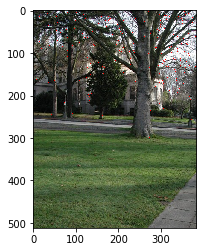

(20535, 2)
change x 0.6055535866320133
change y 0.5604775062794245
change x 0.500479572217895
change x 0.556783259425129
change y 0.7886930136948882
change y 0.5394988540510132
change x 0.570860884473281
change y 0.5509448456345828
change x 0.542706687645138
change x 0.689337292741267
change y 0.6008644102354722
change x 0.6829152774886714
change y 0.5225423007586502
change y 0.5223526721630204
change x 0.588212341949365
change y 0.6145774631433432
change x 2.0668379093164058
change y 0.865735634525893
change y 0.5097596824943541
change y 1.3164915322101662
change x 0.5064353672477229
change x 2.3645397007117674
change x 0.5341998572612634
change y 0.5031212373862919
change x 0.522189817341684
change y 0.530606116439779
change x 0.841155431576915
change y 0.8916501553411378
change y 0.5349280267354477
change x 0.5411886845707802
change y 0.585743266245073
change y 0.5500756125446431
change y 0.5491729131815524
change x 0.5620059020759526
change x 1.2906629268609242
change y 0.823915605

(21176, 2)
change y 0.5397147582495321
change x 0.5615414261446815
change x 0.5271532173243259
change y 12.756892118949855
change y 0.5195155694069808
change x 0.5658260635020754
change y 0.5896971642556792
change y 0.508173080208489
change x 1.3927412076213557
change y 0.6588894020886636
change y 0.5987213321466043
change y 0.5249338897412659
change y 0.9358077876161874
change y 0.6634606925529518
change y 0.6484914379406013
change x 0.5772921504809554
change x 0.5392340617347001
change x 1.3093710321271947
change y 0.5064154436339742
change x 0.5117250595447886
change x 0.5039225536627936
change y 0.5189925726515989
change x 0.5292380866317161
change y 0.5034099667935071
change x 1.03131211943243
change x 0.5167180356032568
change y 0.6628004533606653
change x 0.5665604217053009
change x 0.5560037200344056
change y 0.5125533255404332
change x 0.5266688674111059
change y 0.7597675252746628
change x 1.442047048877911
change x 0.7220397512834925
change x 0.5133396427149676
change x 0.64

(20170, 2)
change x 0.501985539716339
change x 0.6261154841197292
change y 0.7104473375407443
change x 0.5426866965694804
change y 0.5043838566738701
change y 0.5064398473083226
change y 0.5162088396504928
change y 0.5325697739158279
change x 0.6173162878124959
change y 0.5011505064789878
change y 0.5110598440125741
change y 0.591820024967776
change x 0.5226892839974784
change y 0.5806731227221144
change x 0.5379850575984134
change y 0.6810722771129537
change y 2.199589935374627
change y 0.5099449935980093
change y 0.5857395332500374
change x 0.520718395388007
change y 0.6351330775050501
change x 0.5653841605570068
change x 0.513845380029161
change y 0.6174190030025057
change x 0.8619043637655113
change y 0.6057316846481839
change y 0.5169831867736825
change x 0.9810518338963494
change x 2.3133632119523133
change y 3.680104557603065
change y 3.909971259321914
change x 4.034325012354868
change x 0.9385626508151554
change x 0.5047069167496565
change y 0.6440604943227305
change x 0.500488

(20343, 2)
change x 0.5344484933601197
change x 2.9485529548886604
change x 0.5004334480497034
change x 0.5145908807017004
change x 0.5907984643814306
change y 0.535591109423576
change y 0.5217528771464159
change x 0.5943376694616778
change x 0.5016117910623974
change y 0.531241449219195
change y 0.5438648728655696
change y 0.5196818495232303
change y 0.553225852256819
change x 0.6166411926919184
change y 0.5780282641889724
change y 0.5109859572890965
change x 0.5913203586343412
change x 0.5383762836068307
change y 0.5069990984872434
change y 0.6215268222064407
change x 0.7642022843475643
change y 0.6415723347792498
change x 0.5850158598718423
change y 0.5341764316593247
change x 0.5170533644733479
change y 0.5024062596907376
change y 0.5017736179717108
change y 0.5136271015019155
change y 0.5695300057818264
change x 0.5903471832584456
change y 1.2430691083069114
change x 0.8248605538372177
change x 0.532679874109112
change x 0.5447637803443054
change y 0.6058491372301543
change x 0.81

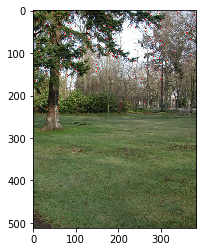

(27502, 2)
change x 0.7244798614409513
change y 0.5510252093472633
change y 1.0109349506615664
change y 0.6481372014680444
change x 0.5651420987578263
change x 0.5273174771744316
change y 0.5765204445615276
change y 0.5835281767925166
change y 0.5070479474384224
change x 0.5226363976035936
change y 0.5009371176716575
change x 0.5518069915901292
change y 0.5001450172781137
change y 6.6640885334064865
change y 0.5233498097624207
change x 0.5838308636059404
change y 0.67121226290767
change y 12.257575811384948
change x 2.1477493297105474
change x 2.3252061054084976
change x 0.5508022768436964
change y 0.5042255785811804
change x 0.569133339949797
change x 0.5598591536313499
change y 0.5140796181406828
change y 0.5730466533771338
change y 0.513359047053191
change x 0.6851420988201312
change y 0.5991283836481907
change x 0.6360694080602529
change y 0.5046123934972774
change x 0.5242382575408912
change y 0.5445469133791854
change y 0.5340998643456007
change y 1.0098063068581018
change x 0.56

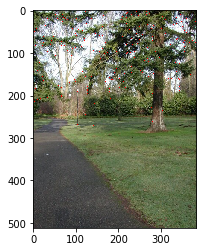

(25311, 2)
change x 0.5360198629771271
change x 0.521672986309315
change x 0.5035916519734508
change y 0.5217139086803355
change y 0.563984124512298
change x 0.5431066354677908
change x 0.5044687999238199
change x 0.519584098922105
change x 0.5529322518967245
change y 0.5106897506454405
change x 0.5256652728784307
change x 0.5014516603062494
change y 1.2132348769060637
change y 0.5594375417527069
change y 0.5694453143056899
change y 0.5989671234104831
change x 0.9707924067864951
change y 0.5951311885480896
change y 0.630544181982365
change x 0.5237752771416364
change y 0.5061779066858006
change x 0.5413532262955293
change x 0.7289581428105668
change y 1.4776271037299225
change y 0.5487848438204659
change y 0.6826606986815116
change y 0.5002300789794387
change x 0.7228368354169548
change x 0.6506912685269562
change y 0.5689647694498426
change y 0.5407099578107902
change y 0.5498479034236111
change x 0.5289029928058226
change x 0.6166731329774374
change y 0.5713345379184043
change x 0.71

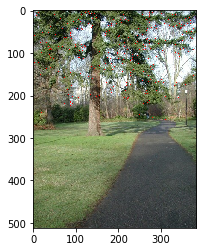

(18420, 2)
change y 0.5585658676790883
change y 0.5135968253965968
change x 0.5323192600228115
change y 0.5159682427514833
change y 0.5344047922216215
change x 0.5081501288298638
change x 0.7480239369836238
change y 0.6155741581812565
change x 0.5093987318051433
change y 0.5027517068964745
change y 0.5064465016932072
change x 0.5183828986142653
change y 0.5062490475376958
change y 0.6668108793495737
change x 0.6828278132177612
change x 0.6233276359285299
change y 0.532743985905378
change y 0.6457459873130676
change x 1.1361077446584982
change y 0.5456854454002634
change x 0.6320852733074273
change x 0.5658813137514496
change x 0.5644657243379534
change x 1.3862547844097133
change y 0.7864719780095729
change y 0.6236493079936627
change x 0.5516773156643283
change x 0.6913002782370294
change y 0.6539796826887778
change y 0.5277751964141926
change y 0.6057074645847332
change x 0.5218473179415474
change y 0.5481808919083522
change y 0.5040395191430657
change x 0.6623286547671465
change y 0

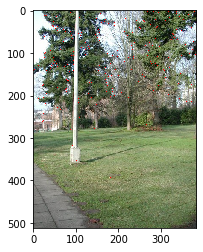

(18723, 2)
change x 0.5436682915490155
change y 0.5208721507147286
change x 0.5883332117119304
change y 0.8843096368766068
change x 1.8510394229515912
change x 0.7185514640965881
change y 0.5345945263839196
change y 0.5354699974209984
change x 0.6583995779212987
change x 0.7251000069754601
change y 0.6567601403965172
change y 5.412068882768718
change y 0.5470727800185482
change y 0.501464040421272
change y 0.6186759525956386
change y 0.508312154592142
change x 0.9915901323518568
change y 0.8353807155996109
change x 0.5712604865698955
change y 0.5556008908066605
change y 0.5001182855582895
change y 0.5175794307446695
change y 0.5273030843163014
change y 0.530427692008318
change y 0.5057550590371499
change y 0.5689109648400891
change y 0.6375721892405712
change y 0.8677197237893352
change y 0.5719899968842335
change x 0.5282486423262845
change y 0.5672592992603109
change x 0.5070716132025412
change y 0.5856104107508047
change x 3.3911285316678756
change y 0.525414149413193
change y 0.519

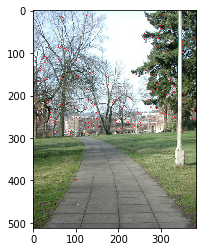

(35442, 2)
change x 0.6790092954149898
change y 1.339818697904386
change x 0.8627469421599052
change y 0.5382481461227456
change y 0.5668301410212336
change y 0.5788825730422056
change y 0.5201050314097283
change x 0.5130322276937072
change y 0.5149537093687029
change y 0.5525376715230205
change x 1.158693895367165
change y 0.7558451252255378
change x 1.639711272466266
change x 0.675537557881152
change y 0.5927670369829497
change x 0.5910767768181436
change y 0.9035347291778679
change x 0.6882854006110428
change y 0.5794717739613741
change y 0.5827125910657658
change y 0.505252563768645
change x 0.5667167759684576
change y 0.5068530848649345
change x 0.5118389505802318
change x 0.8330541486791481
change y 0.7816843071721085
change x 1.724165216459967
change y 1.364593223119173
change y 0.6578087986324019
change x 0.805834658127669
change y 0.6059413611744857
change x 0.513625355827581
change y 0.5446853042490156
change x 0.5050005366712033
change x 0.5014486090734164
change y 0.6995458

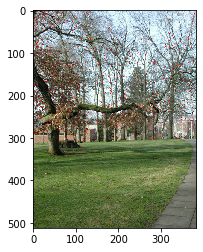

(17410, 2)
change x 0.5277093981870797
change x 0.5141107871632317
change x 0.6117353241175431
change x 0.5300865338112496
change x 3.1481032856345177
change y 0.570171717147911
change x 0.5311445536950437
change y 0.9144146426434837
change y 0.5497787085116994
change x 0.5351079335865349
change y 0.5106703806977272
change y 0.6329594405779977
change x 0.5522142399765838
change y 0.5329121439275403
change x 0.5023174339994445
change y 0.5730669974335099
change x 0.6393875376721856
change y 0.9019610631221375
change x 0.5484449725594587
change y 0.5032568273204296
change y 0.5350235004763894
change x 0.5600751841862325
change y 0.588776091623367
change x 0.50868000363095
change y 0.516754866530757
change x 0.531730129665269
change y 0.5281598512844821
change y 0.640602774183068
change x 0.7975184969409531
change y 0.5005116390966798
change x 0.5651590299693665
change x 0.5050591904642673
change y 0.5715981763304825
change x 0.5209096454168575
change y 0.5527396477425518
change y 0.56062

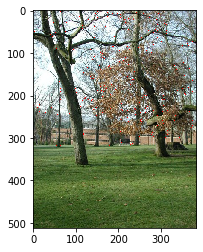

(21627, 2)
change x 3.4872741116316774
change y 0.5212854310950962
change x 0.6032180601613155
change y 0.5053222992107783
change y 0.5356281159343952
change x 0.8267597625410643
change x 0.655865797449949
change x 0.5590936386887132
change y 0.5331189812406002
change x 0.5682573929366379
change x 0.5209888177599513
change y 0.6582189720202872
change y 0.5031973287216811
change x 42.34399989369311
change y 18.010751963372666
change y 1.3145062280587947
change x 0.8523037860362433
change y 0.5458569645852381
change x 0.5303793457845274
change y 0.7082197393263827
change y 0.5381134905056966
change y 0.937370326510611
change y 0.5264300264696108
change x 0.6600520738466873
change y 0.5336140306769972
change x 0.529591993073237
change y 0.5721815392175642
change x 0.5188263421558754
change x 0.6110958030504858
change y 0.5008208200681846
change x 0.6416892584700442
change y 0.5413037270380583
change x 0.538333625051479
change x 0.7252802251059205
change y 0.7435865739085219
change x 0.614

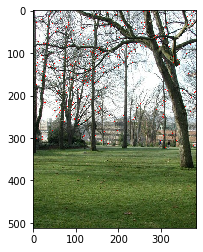

(26733, 2)
change y 0.5244647324246009
change x 4.209375414094314
change y 2.7544333632057483
change x 0.5099135488438196
change x 0.6566976804346253
change y 0.5355077613737307
change x 0.552020193366431
change y 0.5136860657877315
change x 0.7366013060844838
change y 0.714960074008302
change y 0.7452228121848102
change x 0.5467547561508326
change x 0.5309932389027169
change y 0.6499432829107109
change x 0.602964742077112
change y 0.5902647874952425
change y 0.5029212654641095
change y 0.8335734287275092
change y 0.7003367138442484
change x 0.5076257916275021
change y 0.5041231554105131
change y 0.5333946407869965
change x 0.5017962151402249
change y 0.5159625025824166
change y 0.9373043304259568
change x 0.5834800971620978
change y 0.5742257979798248
change y 0.5620531954360164
change y 0.5330956253414134
change y 0.5274229809694314
change y 0.5402760740721759
change x 0.5314970194598966
change y 0.5400177231356884
change y 0.6194018474095105
change x 0.5183170169594847
change x 0.51

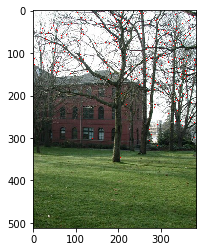

In [63]:
for i in range(len(img_set)):
    key_points = HarrisCornerDetector(img_gray[i])
    print(key_points.shape)
    drawPoints(img_set[i], key_points)

#_ = HarrisLib(img_set[0])

f_HM


<ipython-input-67-aac17b4de33c>:170: RuntimeWarning: invalid value encountered in true_divide
  f_HM.append(det_H / tr_H)


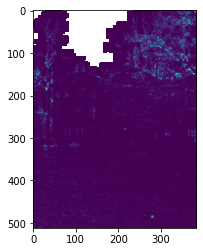

<ipython-input-67-aac17b4de33c>:3: RuntimeWarning: invalid value encountered in greater
  coords = np.argwhere(I > threshold)


(0, 2)
f_HM


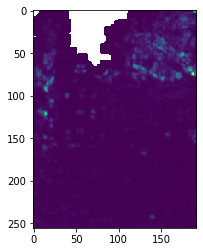

(0, 2)
f_HM


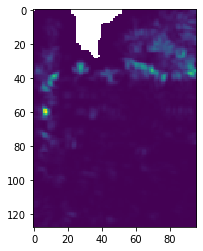

(0, 2)


In [68]:
MSOP(img_gray[0])